# Probabilistic Programming - 2

### Preliminaries

- Goal 
  - Write a probabilistic program for a mixture model
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - Cheatsheets: how does Julia differ from Matlab / Python (https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).
    - Getting started with ForneyLab (https://biaslab.github.io/forneylab/docs/getting-started/).
    - Tutorials using Turing.jl (https://turing.ml/dev/tutorials/0-introduction/)

Today we'll continue to write more complicated models with ForneyLab and Turing.

### Mixture modeling - Synthetic data

We will first generate a synthetic data set to play around. This will let us focus on the data-generating process and on the point that a good model should follow the data-generating process.

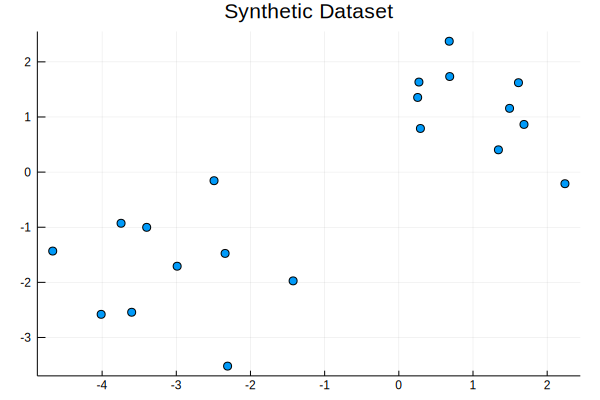

In [1]:
using Distributions
using StatsPlots
using Random

# Set a random seed.
Random.seed!(3)

# Construct 10 data points for each cluster.
N = 10

# Means for each cluster, assuming each cluster is Gaussian distributed
μ1 = [-1, -1]
μ2 = [+1, +1]

# Concatenate means
μs = [μ1 μ2]

# Construct the data points.
X = mapreduce(c -> rand(MvNormal(μs[:, c], 1.), N), hcat, 1:2)

# Visualization.
scatter(X[1,:], X[2,:], legend = false, title = "Synthetic Dataset")

In [2]:
using Turing
using MCMCChains
Turing.setadbackend(:forward_diff);

In [3]:
@model GaussianMixtureModel(x, m1, m2) = begin
    
    D, N = size(x)

    # Draw the mean for cluster 1 [2x1 vector]
    μ1 ~ MvNormal(m1, 1.)
    
    # Draw the mean for cluster 2 [2x1 vector]
    μ2 ~ MvNormal(m2, 1.)
    
    # Concatenate means [2x2 matrix]
    μ = [μ1 μ2]
    
    # Probability of belonging to each cluster [2x1 vector]
    w = [0.5, 0.5]
    
    # Preallocate assignment vector [Nx1 vector]
    k = Vector{Int}(undef, N)
    
    # Loop over observations
    for i in 1:N
        
        # Draw assignment for i-th sample from a Categorical distribution parameterized by w
        k[i] ~ Categorical(w)
        
        # Data point x[i] follows a normal distribution, with mean indexed by the assignment variable k[i]
        x[:,i] ~ MvNormal(μ[:, k[i]], 1.)
    end
    
    # Return the assignments
    return k
end

GaussianMixtureModel (generic function with 4 methods)

In [4]:
# Set priors
m1 = [-2, -2]
m2 = [0, 0]

# Create an instance of a model, using the synthetic data set X
gmm_model = GaussianMixtureModel(X, m1, m2);

We now have a data set and a model. To arrive at class assignments for each data point, we need to perform inference. As stated before, there are two main schools of thought in Bayesian inference: Monte Carlo sampling and variational approximations. Below, we will use a particular form of Monte Carlo sampling, called Gibbs sampling.

In [5]:
# Construct Gibbs sampler
gmm_sampler = Gibbs(100, PG(100, 1, :k), HMC(1, 0.05, 10, :μ1, :μ2))

# Start sampling
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler), chainscat, 1);

[Gibbs] Sampling...100% Time: 0:00:57
┌ Info: [Gibbs] Finished with
└ @ Turing.Inference /home/wmkouw/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:185
┌ Info:   Running time    = 56.25959036499998;
└ @ Turing.Inference /home/wmkouw/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:186


In [6]:
# Extract the means over the MCMC chains for the posterior means
μ1_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ1].value.data[:,:,1]; dims=1)));
μ2_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ2].value.data[:,:,1]; dims=1)));

# Report difference between estimated mean and true mean for cluster 1
println("Difference between μ1 and μ1_estimated = "*string(abs.(μ1 - μ1_estimated)))

# Report difference between estimated mean and true mean for cluster 2
println("Difference between μ2 and μ2_estimated = "*string(abs.(μ2 - μ2_estimated)))

Difference between μ1 and μ1_estimated = [0.503557, 0.72829]
Difference between μ2 and μ2_estimated = [0.0690386, 0.0376548]


In [7]:
function predict(x, y, w, μ1, μ2)
    "Compute posterior probabilities of samples under model"
    
    # Probability under cluster 1
    logp1 = log(w[1]) + logpdf(MvNormal(μ1, 1.), [x, y])
    
    # Probability under cluster 2
    logp2 = log(w[2]) + logpdf(MvNormal(μ2, 1.), [x, y])
    
    # Add probabilities using log-sum-exp trick for numeric stability.
    return Turing.logaddexp(logp1, logp2)
end

predict (generic function with 1 method)

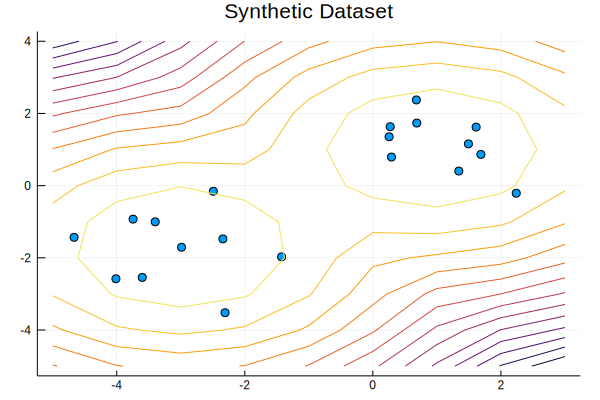

In [8]:
# Show the data
scatter(X[1,:], X[2,:], legend = false, title = "Synthetic Dataset")

# Overlay the posterior probability
x1 = range(-5, stop=3)
x2 = range(-5, stop=4)
contour!(x1, x2, (x, y) -> predict(x, y, [0.5, 0.5], μ1_estimated, μ2_estimated))

Let's take a closer look at the chain. 

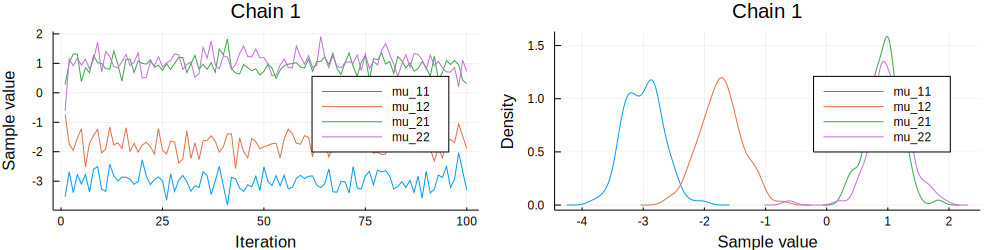

In [9]:
# Find the means within the chain
ids = findall(map(name -> occursin("μ", name), names(tchain)));

# Plot the course of the chains
p=plot(tchain[:, ids, :], legend=true, labels = ["mu_11" "mu_12" "mu_21" "mu_22"], colordim=:parameter)

### Mixture modeling - natural data

Let's have another look at the Old Faithful data set. 

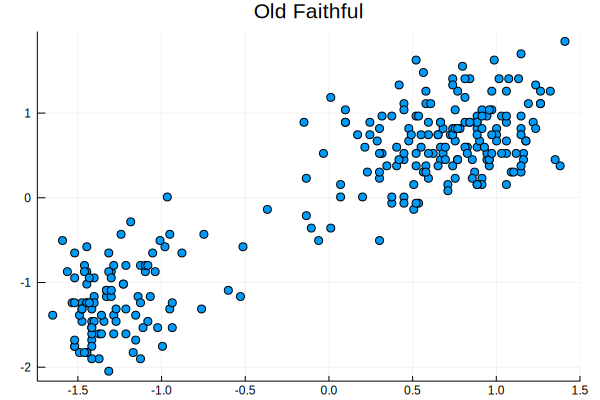

In [10]:
using DataFrames
using CSV
using LinearAlgebra

# Read file
old_faithful = CSV.read("datasets/old_faithful.csv")

# Convert file to matrix
X = convert(Matrix{Float64}, [old_faithful[1] old_faithful[2]])

# Center the data
X = X .- mean(X, dims=1)

# Normalize by standard deviation
X = X ./ std(X, dims=1)

# Scatter data points
scatter(X[:,1], X[:,2], legend=false, title="Old Faithful")

In [11]:
mean(X.>0,dims=1)

1×2 Array{Int64,2}:
 167  164

First of all, we should specify the model that we believe generated the data. 

In [12]:
# Set priors
m1 = [-1, -1]
m2 = [+1, +1]

# Call another instance of the model for this data set
gmm_model = GaussianMixtureModel(X', m1, m2);

In [28]:
# Construct a Gibbs sampler
gmm_sampler = Gibbs(50, PG(100, 1, :k), HMC(1, 0.05, 10, :μ1, :μ2))

# Start sampling+++
tchain = mapreduce(c -> sample(gmm_model, gmm_sampler), chainscat, 1);

[Gibbs] Sampling...100% Time: 0:24:15
┌ Info: [Gibbs] Finished with
└ @ Turing.Inference /home/wmkouw/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:185
┌ Info:   Running time    = 1454.3925342869998;
└ @ Turing.Inference /home/wmkouw/.julia/packages/Turing/RZOZ8/src/inference/gibbs.jl:186


As you may start to realize, sampling is slow.

In [21]:
# Means of distributions
μ1_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ1].value.data[:,:,1]; dims=1)));
μ2_estimated = vec(convert(Array{Float64,2}, mean(tchain[:μ2].value.data[:,:,1]; dims=1)));

# Report estimated mean for each cluster
println("μ1_estimated = "*string(μ1_estimated))
println("μ2_estimated = "*string(μ2_estimated))

μ1_estimated = [-0.410807, -0.623364]
μ2_estimated = [0.78646, 0.595859]


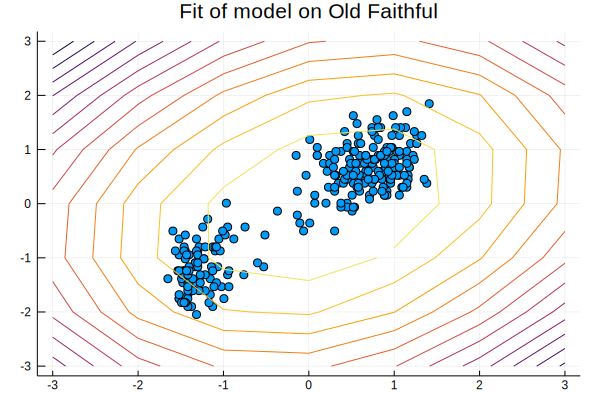

In [26]:
# Plot iso-probability lines
x1 = range(-3, stop = 3)
x2 = range(-3, stop = 3)

# Scatter points
scatter(X[:, 1], X[:,2], legend=false, title="Fit of model on Old Faithful")
contour!(x1, x2, (x, y) -> predict(x, y, [0.5, 0.5], μ1_estimated, μ2_estimated))

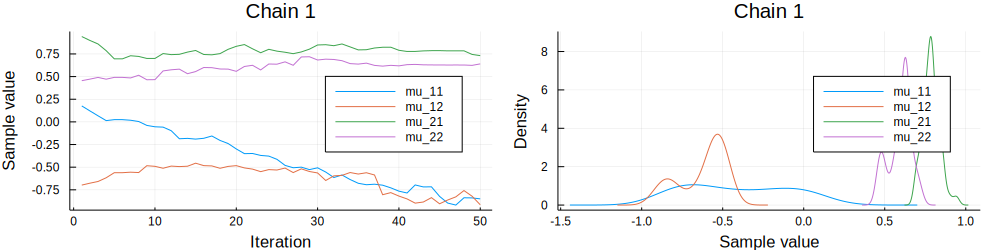

In [27]:
# Find the means within the chain
ids = findall(map(name -> occursin("μ", name), names(tchain)));

# Plot the course of the chains
p=plot(tchain[:, ids, :], legend=true, labels = ["mu_11" "mu_12" "mu_21" "mu_22"], colordim=:parameter)

## Inference through variational approximation

Now, we move away from sampling and towards variational approximations. With variational approaches, you also have to specify a model of how the data was generated.

In [17]:
using ForneyLab

g = FactorGraph()

# Specify generative model
@RV _pi ~ Beta(1.0, 1.0)
@RV m_1 ~ GaussianMeanVariance(0.0, 100.0)
@RV w_1 ~ Gamma(0.01, 0.01)
@RV m_2 ~ GaussianMeanVariance(0.0, 100.0)
@RV w_2 ~ Gamma(0.01, 0.01)

z = Vector{Variable}(undef, n)
y = Vector{Variable}(undef, n)
for i = 1:n
    @RV z[i] ~ Bernoulli(_pi)
    @RV y[i] ~ GaussianMixture(z[i], m_1, w_1, m_2, w_2)
    
    placeholder(y[i], :y, index=i)
end

UndefVarError: UndefVarError: Beta not defined

Now, you need to specify a distribution with which you will approximate the posterior distribution that you would normally obtain through exact Bayesian inference.

In [18]:
# Specify recognition factorization (mean-field)
q = RecognitionFactorization(_pi, m_1, w_1, m_2, w_2, z, ids=[:PI, :M1, :W1, :M2, :W2, :Z])

# Generate the algorithm
algo = variationalAlgorithm(q)
algo_F = freeEnergyAlgorithm(q);

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algo_F));

UndefVarError: UndefVarError: m_1 not defined

Now, we execute the algorithm

In [19]:
data = Dict(:y => y_data)

# Prepare recognition distributions
marginals = Dict(:_pi => vague(Beta),
                 :m_1 => ProbabilityDistribution(Univariate, GaussianMeanVariance, m=-1.0, v=1e4),
                 :w_1 => vague(Gamma),
                 :m_2 => ProbabilityDistribution(Univariate, GaussianMeanVariance, m=1.0, v=1e4),
                 :w_2 => vague(Gamma))
for i = 1:n
    marginals[:z_*i] = vague(Bernoulli)
end

# Execute algorithm
n_its = 10
F = Float64[]
for i = 1:n_its
    stepZ!(data, marginals)
    stepPI!(data, marginals)
    stepM1!(data, marginals)
    stepW1!(data, marginals)
    stepM2!(data, marginals)
    stepW2!(data, marginals)
        
    # Store variational free energy for visualization
    push!(F, freeEnergy(data, marginals))
end

UndefVarError: UndefVarError: y_data not defined

Visualize the results.

In [20]:
using PyPlot

# Plot free energy to check for convergence
figure(figsize=(8,4))
subplot(121)
plot(1:n_its, F, color="black")
grid("on")
xlabel("VMP iteration")
ylabel("Variational free energy")

# Plot data
subplot(122)
scatter(y_data[z_data], -0.25*ones(sum(z_data)), color="blue", linewidth=2, marker=".")
scatter(y_data[.!z_data], -0.25*ones(sum(.!z_data)), color="orange", linewidth=2, marker=".")

# Plot estimated distribution
x_test = range(-4, stop=4, length=200)
d1_est = Normal(mean(marginals[:m_1]), sqrt(var(marginals[:m_1])))
d2_est = Normal(mean(marginals[:m_2]), sqrt(var(marginals[:m_2])))
pi_est = mean(marginals[:_pi])
gmm_pdf = pi_est * pdf.(Ref(d1_est), x_test) + (1-pi_est) * pdf.(Ref(d2_est), x_test)
plot(x_test, gmm_pdf, color="k")
xlabel(L"y")
ylabel(L"p(y|\mathcal{D})")
xlim([-4,4])
grid()
tight_layout()

UndefVarError: UndefVarError: n_its not defined